In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, trace
import jax
import jax.numpy as jnp
from jax import random
from jax.scipy.integrate import trapezoid
import numpy as np

from sim_utils import *
from clip import *
import matplotlib.pylab as plt

/home/frans/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def vmapped_sim_fn(sim_fn, params):
    # print(jax.tree_map(lambda x: x.shape if hasattr(x, 'shape') else None, params))
    if params['L'].ndim == 1:
        return jax.vmap(sim_fn, in_axes=0, out_axes=0)(params)
    else:
        return jax.vmap(partial(vmapped_sim_fn, sim_fn), in_axes=0, out_axes=0)(params)

In [301]:
def sim_worms_orig(nworms, batch_size, n_frames):
    duration = 0.55
    snapshots = 10
    kpoints = 6
    box_size = 64
    with numpyro.plate('batch', batch_size, dim=-2):
        with numpyro.plate('nworms', nworms, dim=-1):
            # L = numpyro.sample('L', dist.Uniform(30, 45))
            L = numpyro.sample('L', dist.Uniform(10, 15))
            A = numpyro.sample('A', dist.Normal(1, 0.1))
            T = numpyro.sample('T', dist.Normal(0.8, 0.1))
            kw = numpyro.sample('kw', dist.Uniform(0, 2 * jnp.pi))
            ku = numpyro.sample('ku', dist.Normal(jnp.pi, 1))
            
            inc = numpyro.sample('inc', dist.Uniform(0, 2 * jnp.pi))
            dr = numpyro.sample('dr', dist.Uniform(0.2, 0.8))
            phase_1 = numpyro.sample('phase_1', dist.Uniform(0, 2 * jnp.pi))
            phase_2 = numpyro.sample('phase_2', dist.Uniform(0, 2 * jnp.pi))
            phase_3 = numpyro.sample('phase_3', dist.Normal(0, 0.1))
            alpha = numpyro.sample('alpha', dist.Normal(4, 4))

            alpha = jnp.abs(alpha + 1.0)
            half_box = box_size // 2
            x0 = numpyro.sample('x0', dist.Uniform(-1, 1))
            y0 = numpyro.sample('y0', dist.Uniform(-1, 1))
            x0 = x0 * half_box
            y0 = y0 * half_box

            params = {'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}

            sim_fn = partial(
                worm_simulation,
                duration=duration,
                snapshots=snapshots,
                kpoints=kpoints,
            )

            with numpyro.plate('n_frames', n_frames):
                worms = vmapped_sim_fn(sim_fn, params)
                worms = worms + half_box
                # subtract mean and divide by standard deviation
                # worms = (worms - jnp.mean(worms, axis=(-5), keepdims=True)) / jnp.std(worms, axis=(-5), keepdims=True)
                numpyro.deterministic('worms', worms)
    return worms, x0, y0

In [344]:
def sim_worms(nworms, batch_size, n_frames):
    duration = 0.55
    snapshots = 10
    kpoints = 6
    box_size = 64
    with numpyro.plate('batch', batch_size, dim=-2):
        with numpyro.plate('nworms', nworms, dim=-1):
            # L = numpyro.sample('L', dist.Uniform(30, 45))
            L = numpyro.sample('L', dist.Uniform(10, 15))
            A = numpyro.sample('A', dist.Normal(1, 0.1))
            T = numpyro.sample('T', dist.Normal(0.8, 0.1))
            kw = numpyro.sample('kw', dist.Uniform(0, 2 * jnp.pi))
            ku = numpyro.sample('ku', dist.Normal(jnp.pi, 1))
            
            inc = numpyro.sample('inc', dist.Uniform(0, 2 * jnp.pi))
            dr = numpyro.sample('dr', dist.Uniform(0.2, 0.8))
            phase_1 = numpyro.sample('phase_1', dist.Uniform(0, 2 * jnp.pi))
            phase_2 = numpyro.sample('phase_2', dist.Uniform(0, 2 * jnp.pi))
            phase_3 = numpyro.sample('phase_3', dist.Normal(0, 0.1))
            alpha = numpyro.sample('alpha', dist.Normal(4, 4))

            alpha = jnp.abs(alpha + 1.0)
            half_box = box_size // 2
            x0 = numpyro.sample('x0', dist.Uniform(-1, 1))
            y0 = numpyro.sample('y0', dist.Uniform(-1, 1))
            # x0 = x0 * half_box
            # y0 = y0 * half_box

            params = {'L': L, 'A': A, 'T': T, 'kw': kw, 'ku': ku, 'inc': inc, 'dr': dr, 'phase_1': phase_1, 'phase_2': phase_2, 'phase_3': phase_3, 'alpha': alpha, 'x0': x0, 'y0': y0}

            sim_fn = partial(
                worm_simulation,
                duration=duration,
                snapshots=snapshots,
                kpoints=kpoints,
            )

            with numpyro.plate('n_frames', n_frames):
                worms = vmapped_sim_fn(sim_fn, params)
                print(worms.shape)
                print(L.shape)
                print(x0.shape)
                worms = worms - jnp.array([x0, y0]).reshape(2, 2, 1, 1, 2)
                # worms = worms / L.reshape(2, 2, 1, 1, 1)
                worms = worms / 12.5
                # worms = worms + half_box
                # subtract mean and divide by standard deviation
                # worms = (worms - jnp.mean(worms, axis=(-5), keepdims=True)) / jnp.std(worms, axis=(-5), keepdims=True)
                numpyro.deterministic('worms', worms)
    return worms, x0, y0

In [345]:
def scale_and_translate(image, where, scale, out_size):
  translate = abs(image.shape[-1] - out_size) * (where[..., ::-1] + 1) / 2
  return jax.image.scale_and_translate(
      image,
      (out_size, out_size),
      (0, 1),
      scale * jnp.ones(2),
      translate,
      method="cubic",
      antialias=False,
  )

In [374]:
def embed_worms(digits, z_where, scale, frame_size=64):
  # digits:  (digits).      .digit_size.digit_size
  # z_where: (digits).(time).2
  # out:     (digits).(time).frame_size.frame_size
  if digits.ndim == 2 and z_where.ndim == 1:
    return scale_and_translate(digits, z_where, scale, out_size=frame_size)
  elif digits.ndim == 2 and z_where.ndim == 2:
    in_axes = (None, 0, 0)
  elif digits.ndim >= z_where.ndim:
    in_axes = (0, 0, 0)
  else:
    in_axes = (None, 0, 0)
  # print("in_axes", in_axes)
  # print(digits.shape)
  # print(z_where.shape)
  return jax.vmap(partial(embed_worms, frame_size=frame_size), in_axes)(
      digits, z_where, scale
  )

In [347]:
# generate a size x size image of  circle
def circle_image(size):
    x = jnp.linspace(-1, 1, size)
    y = jnp.linspace(-1, 1, size)
    xx, yy = jnp.meshgrid(x, y)
    circle = jnp.exp(-(xx ** 2 + yy ** 2)/0.4)
    circle /= circle.max()
    circle += jnp.abs(circle.min())
    return circle

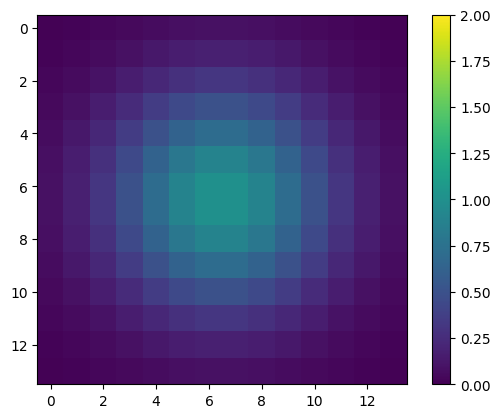

In [348]:
plt.figure()
plt.imshow(circle_image(14), vmin=0, vmax=2)
plt.colorbar()

In [349]:
foo.shape

(6, 14, 14)

In [350]:
# seed and trace
key, nworms, box_size = random.PRNGKey(0), 2, 64


seeded_model = seed(sim_worms, key)
tr = trace(seeded_model).get_trace(nworms=nworms, batch_size=2, n_frames=10)

(2, 2, 10, 6, 2)
(2, 2)
(2, 2)


In [351]:
tr["worms"]["value"].shape

(2, 2, 10, 6, 2)

In [352]:
tr["worms"]["value"][0, 0, 0]

Array([[-0.36054087, -0.4437638 ],
       [-0.2578748 , -0.28211683],
       [-0.10665018, -0.16463837],
       [ 0.06763603, -0.08530124],
       [ 0.23744734,  0.00320981],
       [ 0.36871338,  0.14263459]], dtype=float32)

In [396]:
def make_worm_frames(worms):
    # make worm widths for all knots
    R = 0.8
    K = 6
    i = jnp.arange(K)
    r = R * jnp.abs(jnp.sin(jnp.arccos((i - K / 2) / (K / 2 + 0.2))))
    r = jnp.tile(r, (worms.shape[:-2] + (1,)))

    # draw the circles
    circles = embed_digits(circle_image(4), worms * 2, r, frame_size=14)
    # overlay the circles
    p = dist.util.clamp_probs(circles.mean(-3))
    return p


In [395]:
p.shape

(2, 2, 10, 14, 14)

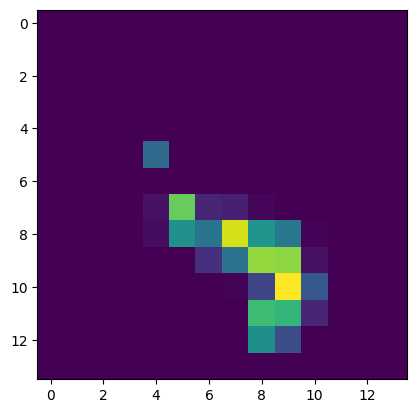

In [408]:
p = make_worm_frames(tr["worms"]["value"])
plt.figure()
plt.imshow(p[0, 1, 2])

In [302]:
seeded_model_orig = seed(sim_worms_orig, key)
tr_orig = trace(seeded_model_orig).get_trace(nworms=nworms, batch_size=2, n_frames=10)

worms = tr_orig['worms']['value'].transpose(0, 2, 1, 3, 4)
clips = jax.vmap(convert_to_clip, in_axes=(0, None))(worms, box_size)

In [303]:
clips.shape

(2, 10, 64, 64)

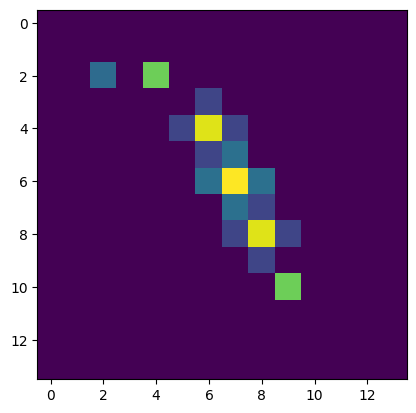

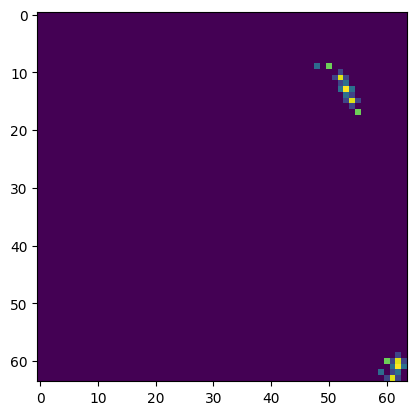

In [312]:
i = 0
frame = 4
plt.imshow(clips[i][frame][7:(7+14), 46:(46+14)])
plt.figure()
plt.imshow(clips[i][frame])
# plot points at means
# plt.scatter(tr['x0']['value'], tr['y0']['value'])
# plt.scatter(worms.mean(axis=-2)[i, frame, ..., 0], worms.mean(axis=-2)[i, frame, ..., 1], c='r')
# plt.scatter(tr['worm']['value'].mean(axis=-2)[0, ..., 0], tr['worm']['value'].mean(axis=-2)[0, ..., 1], c='r')

In [45]:
# seed and trace
key, nworms, box_size = random.PRNGKey(0), 2, 64


seeded_model = seed(sim_worms, key)
tr = trace(seeded_model).get_trace(nworms, 20_000, 10)

In [46]:
tr['worms']['value'].shape

(20000, 2, 10, 6, 2)

In [50]:
worms = tr['worms']['value'].transpose(0, 2, 1, 3, 4)
clips = jax.vmap(convert_to_clip, in_axes=(0, None))(worms, box_size)

In [52]:
# save as npy
np.save('worms_train_20k.npy', clips)

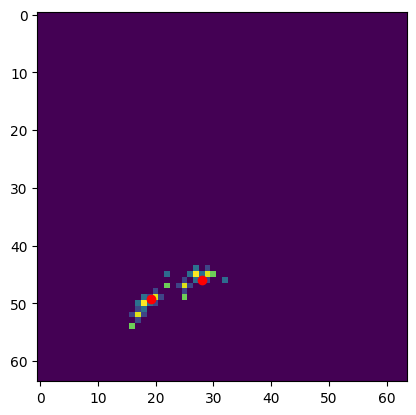

In [61]:
i = 10
frame = 7
plt.imshow(clips[i][frame])
# plot points at means
# plt.scatter(tr['x0']['value'], tr['y0']['value'])
plt.scatter(worms.mean(axis=-2)[i, frame, ..., 0], worms.mean(axis=-2)[i, frame, ..., 1], c='r')
# plt.scatter(tr['worm']['value'].mean(axis=-2)[0, ..., 0], tr['worm']['value'].mean(axis=-2)[0, ..., 1], c='r')